# SGD vs. Bayes in TMS 

Let's run through an example using Anthropic's toy models of superposition. 

This example is mostly to test that our SGLD estimator is working as expected and to figure out how to integrate this in an SGD setting.

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from typing import Iterable, Optional

import wandb
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets

from devinterp.slt.sgld import SGLD, Sampler
from devinterp.zoo.tms import ToyAutoencoder, SyntheticUniformValued, SyntheticBinaryValued

In [27]:
def train(
    model: torch.nn.Module,
    dataset: Dataset,
    batch_size: Optional[int],
    num_epochs: int,
    learning_rate: float,
    log_ivl: Iterable[int],
    wandb_entity: Optional[str] = None,
    wandb_project: Optional[str] = None,
):  
    use_wandb = wandb_entity and wandb_project

    if use_wandb:
        wandb.init(project=wandb_project, entity=wandb_entity)
        wandb.watch(model, log="all")

    batch_size = batch_size or len(dataset)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    logs = pd.DataFrame([{ "loss": None, "acc": None, "step": step} for step in log_ivl]) if not use_wandb else None
    weights = []

    def log(step):
        loss = 0.
        acc = 0.
        length = 0

        for batch in dataloader:
            outputs = model(batch)
            loss += criterion(outputs, batch).item()
            acc += (outputs.round() == batch).float().sum().item()
            length += len(batch)

        loss /= length
        acc /= length

        if use_wandb:
            wandb.log({"loss": loss, "acc": acc, "step": step})
        else:
            logs.loc[logs["step"] == step, ["loss", "acc"]] = [loss, acc]
            encoding_weights = model.embedding.weight.detach().cpu().numpy()
            weights.append(encoding_weights)
            
    step = 0
    log(step)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        for batch in dataloader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            step += 1

            if step in log_ivl:
                log(step)

    if use_wandb:
        wandb.finish()

    return logs, weights


Training: 100%|██████████| 100/100 [00:00<00:00, 250.14it/s]


<Axes: xlabel='step'>

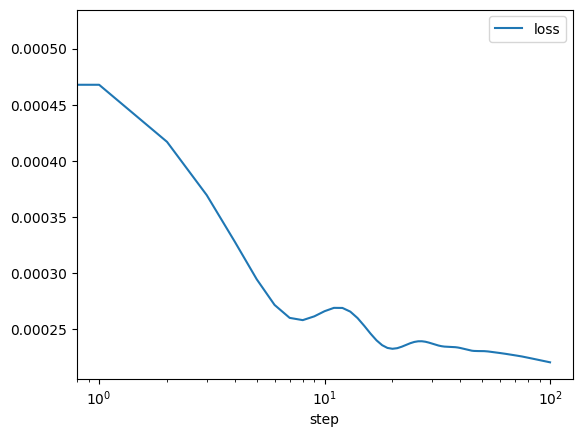

In [28]:
dataset = SyntheticBinaryValued(1000, 5, 0.1)
model = ToyAutoencoder(5, 2)
log_ivl = [*range(100), *range(100, 250, 10), *range(250, 1000, 50)]


logs, weights = train(model, dataset, None, 100, 0.01, log_ivl)
logs.plot(y="loss", x="step", logx=True)

interactive(children=(IntSlider(value=0, description='epoch'), Output()), _dom_classes=('widget-interact',))

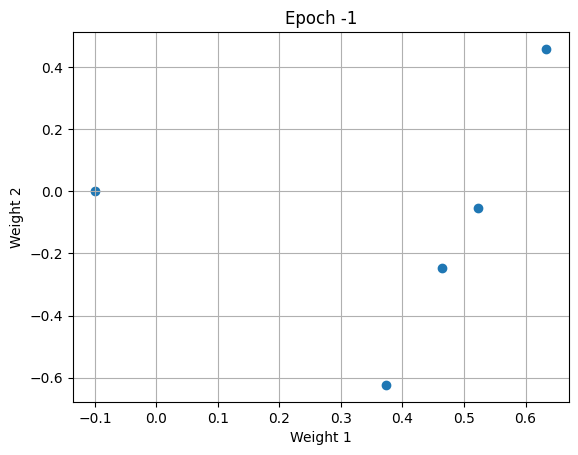

In [29]:
@interact(epoch=widgets.IntSlider(min=0, max=len(weights)-1, step=1, value=0))
def plot_weights(epoch):
    w = weights[epoch]
    
    # for i in range(weights[epoch].shape[-1]):
    #     plt.quiver([0, 0], w[:, i], color='red')
    plt.scatter(w[0, :], w[1, :])

    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title(f"Epoch {epoch}")
    plt.grid(True)
    plt.show()

plot_weights(-1)

In [11]:
weights[0].shape

(2, 10)